# Principal Component Analysis

Principal Component Analysis (PCA) is a technique to reduce the dimensionality of your data. 

### Why do we need it?
Machine learning algorithms can be thought of as function approximators. Given a true mapping from sets $X$ to $Y$, say $g(x), x \in X$, a machine learning algorithm $A$ can be thought of as a function $f: X \rightarrow Y$ where $|g(x)-f(x)|$ can (in many common use-cases) be made as arbitrarily small as you want. The process of making this arbitrarily small is called training the algorithm.

PCA attempts to address the difficulty of high dimensionality in the domain $X$ that often occurs in real datasets. Let us assume that we have a dataset $X$, say of 20000 data points with 350 dimensions per data point.

In [ ]:
"""
Generate a dataset for explanatory purposes.
"""

import numpy as np

# Parameters
n_samples = 20000
n_features = 350
n_classes = 5
effective_rank = 10  # Number of significant dimensions

# simulate latent structure with a low rank matrix
latent = np.random.randn(n_samples, effective_rank)  # Latent data with fewer dimensions
projection = np.random.randn(effective_rank, n_features)  # Projection matrix to high dimensions
data = np.dot(latent, projection)  # High-dimensional data with underlying low-rank structure

# Add some noise
noise = 0.1 * np.random.randn(n_samples, n_features)  # Adding random noise
data += noise

# Generate one-hot encoded target labels
labels = np.random.randint(0, n_classes, size=n_samples)
one_hot_labels = np.eye(n_classes)[labels]  # One-hot encoding

print("The shape of the generated data is:",data.shape)
print("The dataset maps to labels of shape:", one_hot_labels.shape)

The shape of the generated data is: (20000, 350)
The dataset maps to labels of shape: (20000, 5)


Let's train a simple neural network on this data using PyTorch. Using a simple 2-layer fully-connected ANN with ReLU activation, we can train a neural network on the data and get some performance metrics such as training time, training accuracy, and test accuracy. Let's train it for 1000 epochs, to see if we can reach the point of double descent.

Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epochs: 100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


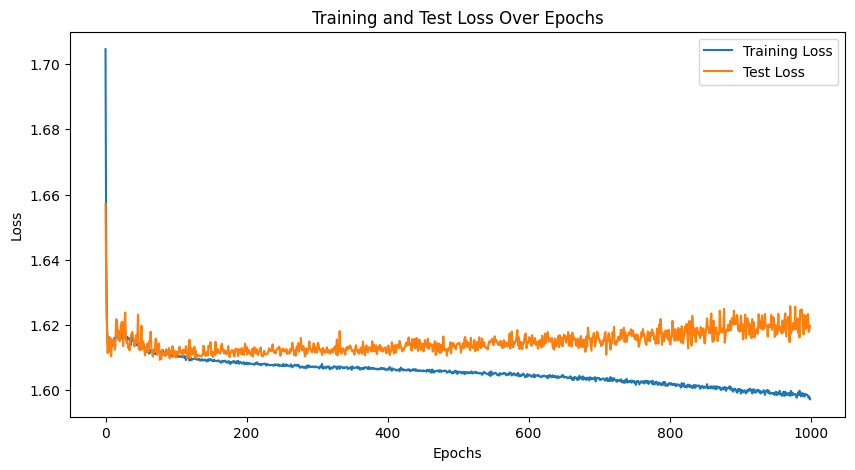

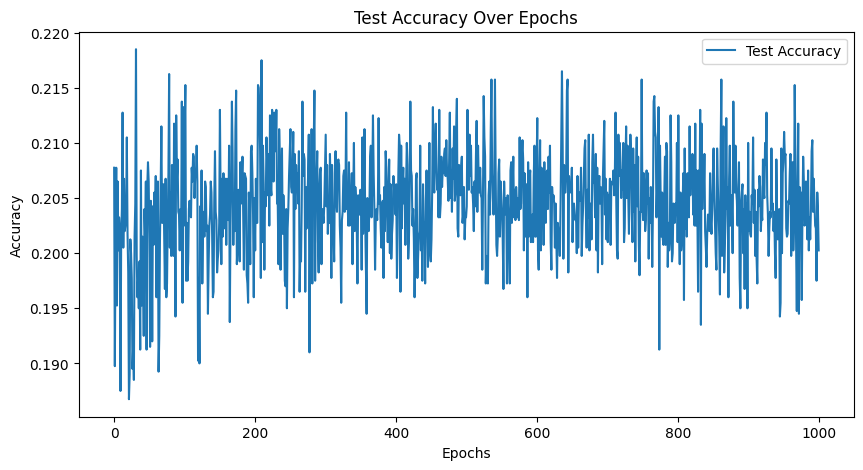

Final Test Accuracy: 0.2003


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Convert numpy arrays to PyTorch tensors
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_tensor, labels_tensor, test_size=0.2, random_state=42)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GPU/CPU configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simple neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model, loss function, and optimizer
input_size = data.shape[1]
num_classes = len(np.unique(labels))
model = SimpleNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing loops with metrics tracking
epochs = 1000
train_losses = []
test_losses = []
accuracy_list = []

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model.train()
    running_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_losses.append(running_train_loss / len(train_loader))
    
    # Evaluate on the test set
    model.eval()
    running_test_loss = 0.0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(batch_y.cpu().numpy())
    test_losses.append(running_test_loss / len(test_loader))
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_list.append(accuracy)

# Plotting training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.show()

# Plotting test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), accuracy_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.show()

print(f"Final Test Accuracy: {accuracy_list[-1]:.4f}")


Well, our neural network isn't that good! We can clearly see that very early on, the network starts to overfit to the training data (~10 epochs in), and the final test accuracy hovers at around 20%

We can see that the neural network took 06:18 minutes to train. Assume that, for some reason, we want to use this architecture on our data - maybe our hardware is optimized for training this specific model. However, we are constrained by the limit that the model should train in under 30 seconds, keeping the number of epochs the same. How can we do this? PCA is a technique we can use to do this.

### The Goal of PCA

Given a set of raw feature vectors $x_1, x_2, x_3,... \in \mathbb{R}^m$ (i.e. m-dimensional data), we want to find a 'useful' feature transformation  $\phi: \mathbb{R}^m \rightarrow \mathbb{R}^k$ where $m \leq k$. 'Useful' can mean several things. For our case, we say 'useful' means that the accuracy of the machine learning model trained on our data after reduction is similar enough to the initial accuracy.

One way to do this is to project the vectors $x_1, x_2, x_3,... \in \mathbb{R}^m$ onto a set of vectors that span the lower-dimensional subspace of dimension $k$. The vectors we project them onto are called the **principal components**. There are several ways to find the principal components, but the most straightforward way is to find the principal components that maximize the variance. This means that the first principal component is along the direction of highest variance of a dataset, the second principal component is along the direction of the second-highest variance, and is orthogonal to the first. The third one is orthogonal to the first and second, and so on. 

The procedure for finding these vectors is as follows:
1. Compute the covariance matrix of the data.
2. Compute the eigenvectors and eigenvalues of the covariance matrix. The eigenvalue corresponding to an eigenvector is a measure of how much variance the eigenvector captures. Why? Intuitively, we want to find a vector $\vec{v}$ that maximizes the sum of projections of all of the data points (say $\textbf{X}$) along it (because this is the direction of maximum variance). This means that we need to solve $max(|\textbf{X}\vec{p}|) \forall p \in \mathbb{R}^m$, which is the same as solving $max (|\textbf{X}\vec{p}|^2)=\vec{p}^T \textbf{X}^T \textbf{X} \vec{p}$. As $\textbf{X}^T \textbf{X}$ is a symmetric square matrix with an eigenbasis, $\vec{p}$ can be expressed as a linear combination of eigenvectors of $\textbf{X}^T \textbf{X}=\sum_{i=0}^{m}a_i\vec{v}_i$, where all $\vec{v}_i$ are orthonormal eigenvectors. This expression is maximized when $a_1=1$ and all others are 0, so the eigenvector with the maximum eigenvalue is the direction of maximum variance.
3. Sort the eigenvalues and eigenvectors in descending order.
4. Select an appropriate number of eigenvectors to take for your use case. Pratically, find where the graph of eigenvalue versus number of principal components becomes an elbow, and take the point of bending as the number of principal components

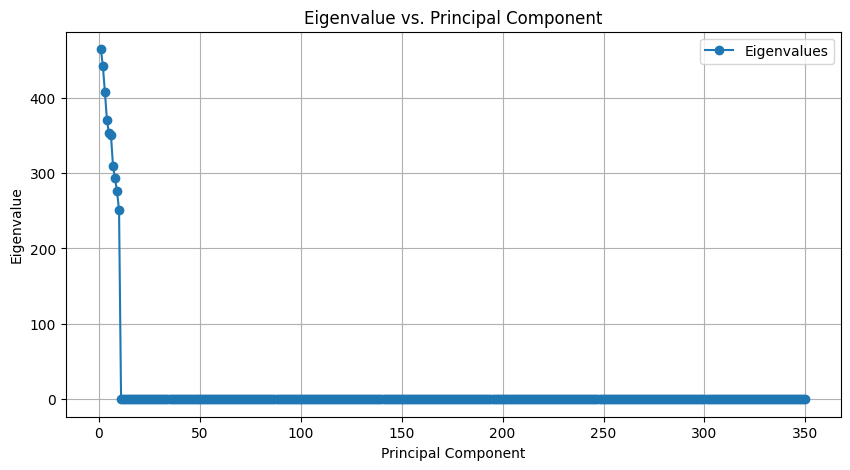

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def pca(data):
    """
    Apply PCA to the given dataset and plot the eigenvalue vs. PCA graph.
    
    Parameters:
    data (numpy.ndarray): The input standardized dataset of shape (n_samples, n_features).
    """
    # Compute the covariance matrix
    covariance_matrix = np.cov(data, rowvar=False)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    
    # Plot eigenvalue vs. PCA graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', label="Eigenvalues")
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    plt.title("Eigenvalue vs. Principal Component")
    plt.grid(True)
    plt.legend()
    plt.show()

pca(data)


We can see after 10 principal components, the eigenvalues are 0. This is because we have 'cheated' a little bit when creating our dataset. We created a high-dimensional matrix with low-rank structure. In practice this technique is still very useful.

Let's now train our model on the reduced dataset and see what happens. Using some 'intuition' that the model will have to be trained for fewer epochs, because of the smaller dataset, we train it for 100 epochs.

Training Epochs: 100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


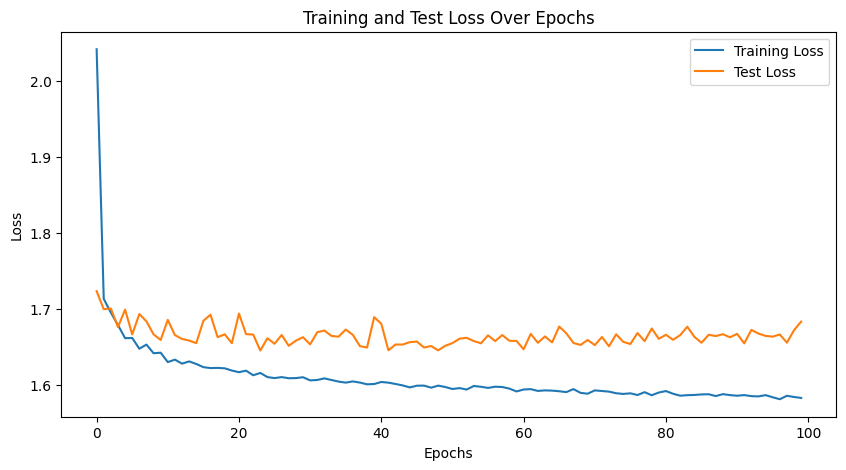

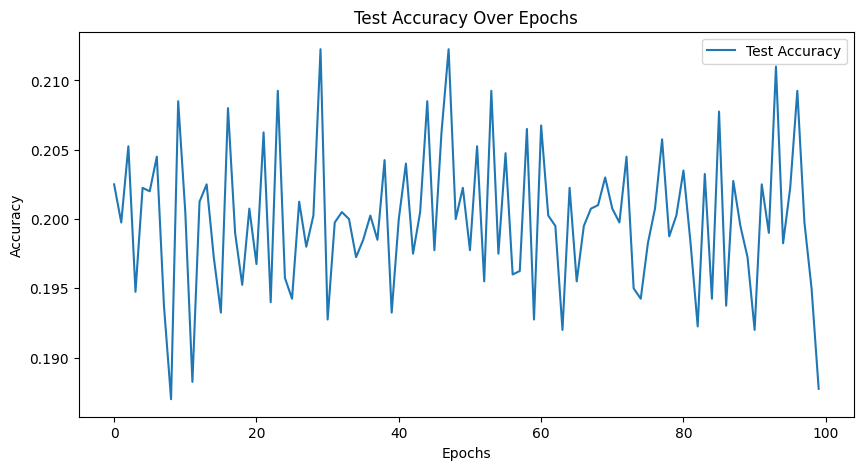

Final Test Accuracy: 0.1878


In [14]:
def load_pca_data(data, n_components):
    """
    Apply PCA to the given dataset and return the transformed data.
    
    Parameters:
    data (numpy.ndarray): The input standardized dataset of shape (n_samples, n_features).
    n_components (int): The number of principal components to retain.
    
    Returns:
    numpy.ndarray: Transformed dataset with reduced dimensions.
    """
    # Compute the covariance matrix
    covariance_matrix = np.cov(data, rowvar=False)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top `n_components` eigenvectors
    selected_eigenvectors = eigenvectors[:, :n_components]
    
    # Project the data onto the selected eigenvectors
    pca_data = np.dot(data, selected_eigenvectors)
    return pca_data

n_components = 10  # Number of components to retain
pca_data = load_pca_data(data, n_components)

# Convert PCA-transformed data to PyTorch tensors
pca_data_tensor = torch.tensor(pca_data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(pca_data_tensor, labels_tensor, test_size=0.2, random_state=42)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# GPU/CPU configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simple neural network architecture for PCA-transformed data
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model, loss function, and optimizer
input_size = pca_data.shape[1]  # Number of PCA components
num_classes = len(np.unique(labels))
model = SimpleNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and testing loops with metrics tracking
epochs = 100
train_losses = []
test_losses = []
accuracy_list = []

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model.train()
    running_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    train_losses.append(running_train_loss / len(train_loader))
    
    # Evaluate on the test set
    model.eval()
    running_test_loss = 0.0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(batch_y.cpu().numpy())
    test_losses.append(running_test_loss / len(test_loader))
    accuracy = accuracy_score(y_true, y_pred)
    accuracy_list.append(accuracy)

# Plotting training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.show()

# Plotting test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), accuracy_list, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.show()

print(f"Final Test Accuracy: {accuracy_list[-1]:.4f}")

For a fraction of the training time, we obtain roughly the same result (even though the result is bad), using the most important components of our data.

PCA is also not limited to supervised learning. PCA is often used in combinations with algorithms such as K-means for clustering and anomaly detection. When working with real data, there is always a tradeoff between speed and accuracy, so dimensionality reduction is often done heuristically.